## TUTORIAL 02 - Elastic block problem
**_Keywords: POD-Galerkin method, vector problem_**

### 1. Introduction
In this Tutorial we consider a linear elasticity problem in a two-dimensional square domain $\Omega$.

The domain is partioned in nine square subdomains, as in the following figure

<img src="data/elastic_block.png" width="35%" />

Parameters of this problem include Young moduli of each subdomain, as well as lateral traction on the right side of square. In particular:
* the ratio between the Young modulus of the each subdomain $\Omega_{p+1}$, $p=0,\dots,7$ and the top-right subdomain $\Omega_9$ is denoted by $\mu_p$, being

$$
\mu_p \in \left[1, 100\right] \qquad \text{for }p=0,\dots,7.
$$

* the horizontal tractions on each boundary $\Gamma_{p-6}$, $p=8,\dots,10$, being

$$
\mu_p \in \left[-1,1\right] \qquad \text{for } p=8,\dots, 10.
$$

For what concerns the remaining boundaries, the left boundary $\Gamma_6$ is clamped, while the top and bottom boundaries $\Gamma_1 \cup \Gamma_5$ are traction free.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \cdots,\mu_{10})
$$
on the parameter domain
$$
\mathbb{P}=[1,100]^8\times[-1,1]^3.
$$

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $\boldsymbol{u}(\boldsymbol{\mu})$ be the displacement in the domain $\Omega$.

In each subdomain $\Omega_{p+1}$, $p=0,\dots,7$, we assume an isotropic linear elastic material, characterized by the following Lamè constants for plane strain
$$\lambda_1(\mu_p) = \frac{\mu_p \nu}{(1+\nu)(1-2\nu)},$$
$$\lambda_2(\mu_p) = \frac{\mu_p}{2(1+\nu)},$$
for $\nu=0.30$, with the following Piola-Kirchhoff tensor

$$
\boldsymbol{\pi}(\boldsymbol{u}; \mu_p) = 
\lambda_1(\mu_p)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\lambda_2(\mu_p)\;\nabla_{S}\boldsymbol{u}
$$
where $\nabla_{S}$ denotes the symmetric part of the gradient.

Similarly, the Piola-Kirchhoff tensor in the top right subdomain $\Omega_9$ is given by $\boldsymbol{\pi}(\boldsymbol{u}; 1)$.

Thus, the Piola-Kirchhoff tensor on the domain $\Omega$ can be obtained as
$$
\boldsymbol{P}(\boldsymbol{u}; \boldsymbol{\mu}) = 
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u}
$$
where
$$
\Lambda_1(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_1(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_1(1) \mathbb{1}_{\Omega_{9}}
$$
$$
\Lambda_2(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_2(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_2(1) \mathbb{1}_{\Omega_{9}}
$$

The strong formulation of the parametrized problem is given by:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $\boldsymbol{u}(\boldsymbol{\mu})$ such that</center>
$$
\begin{cases}
	- \text{div} \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{1},\\
	\boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mu_p \mathbf{n} & \text{on } \Gamma_{p-6}, p=8,\dots, 10,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{5},\\
	\boldsymbol{u}(\boldsymbol{\mu}) = \boldsymbol{0} & \text{on } \Gamma_{6},\\
\end{cases}
$$
<br>

where $\mathbf{n}$ denotes the outer normal to the boundary $\partial\Omega$.

The corresponding weak formulation reads:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that</center>

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{\boldsymbol{v}\in H^1(\Omega; \mathbb{R}^2) : \boldsymbol{v}|_{\Gamma_{6}}=\boldsymbol{0}\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu})=\int_{\Omega}
\left\{
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v}
\right\}  d\boldsymbol{x}
$$,
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(\boldsymbol{v}; \boldsymbol{\mu})= \sum_{p=8}^{10} \mu_p \int_{\Gamma_{p-6}} \boldsymbol{v} \cdot \mathbf{n} \ ds$$.

In [1]:
import sys
sys.path.append("../../MLniCS/")

from mlnics import NN, Losses, Normalization
from dolfin import *
from rbnics import *

import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward. Indeed, owing to the definitions of $\Lambda_1(\boldsymbol{\mu})$ and $\Lambda_2(\boldsymbol{\mu})$, we have:
$$
a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu}) = \sum_{p=0}^7 \underbrace{\mu_{\color{red} p}}_{\Theta^{a}_{\color{red} p}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red}{p + 1}}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} p}(\boldsymbol{u}, \boldsymbol{v})} +\\
\underbrace{1}_{\Theta^{a}_{\color{red} 8}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red} 9}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} 8}(\boldsymbol{u}, \boldsymbol{v})}\\
$$
$$
f(\boldsymbol{v}; \boldsymbol{\mu}) = 
\sum_{p=8}^{10} \underbrace{\mu_{\color{red} p}}_{\Theta^{f}_{\color{red}{p-8}}(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{\color{red}{p-6}}} \boldsymbol{v} \cdot \mathbf{n}}_{f_{\color{red}{p-8}}(\boldsymbol{v})}.
$$

We will implement the numerical discretization of the problem in the class
```
class ElasticBlock(EllipticCoerciveProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(\boldsymbol{u}, \boldsymbol{v})$ and linear forms $f_*(\boldsymbol{v})$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ElasticBlock(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # ...
        self.f = Constant((1.0, 0.0))
        self.E = 1.0
        self.nu = 0.3
        self.lambda_1 = self.E * self.nu / ((1.0 + self.nu) * (1.0 - 2.0 * self.nu))
        self.lambda_2 = self.E / (2.0 * (1.0 + self.nu))

    # Return custom problem name
    def name(self):
        return "ElasticBlock"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            theta_a2 = 1.
            theta_a3 = 1.
            theta_a4 = 1.
            theta_a5 = 1.
            theta_a6 = 1.
            theta_a7 = 1.
            theta_a8 = 1.
            return (theta_a0, theta_a1, theta_a2, theta_a3, theta_a4, theta_a5, theta_a6, theta_a7, theta_a8)
        elif term == "f":
            theta_f0 = mu[1]
            theta_f1 = 1.
            theta_f2 = 1.
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = self.elasticity(u, v) * dx(1)
            a1 = self.elasticity(u, v) * dx(2)
            a2 = self.elasticity(u, v) * dx(3)
            a3 = self.elasticity(u, v) * dx(4)
            a4 = self.elasticity(u, v) * dx(5)
            a5 = self.elasticity(u, v) * dx(6)
            a6 = self.elasticity(u, v) * dx(7)
            a7 = self.elasticity(u, v) * dx(8)
            a8 = self.elasticity(u, v) * dx(9)
            return (a0, a1, a2, a3, a4, a5, a6, a7, a8)
        elif term == "f":
            ds = self.ds
            f = self.f
            f0 = inner(f, v) * ds(2)
            f1 = inner(f, v) * ds(3)
            f2 = inner(f, v) * ds(4)
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant((0.0, 0.0)), self.boundaries, 6)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(u, v) * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

    # Auxiliary function to compute the elasticity bilinear form
    def elasticity(self, u, v):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        return 2.0 * lambda_2 * inner(sym(grad(u)), sym(grad(v))) + lambda_1 * tr(sym(grad(u))) * tr(sym(grad(v)))

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/elastic_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/elastic_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/elastic_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = VectorFunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ElasticBlock class

In [5]:
problem = ElasticBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [
    (1.0, 10.0),
    (-1.0, 1.0)
]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(2e-4)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(500)
reduced_problem = reduction_method.offline()

=                ElasticBlock POD-Galerkin offline phase begins                =

###################################### 0 #######################################
truth solve for mu = (5.939321535345923, 0.43037873274483895)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (6.4248703846447945, 0.08976636599379373)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (4.812893194050142, 0.29178822613331223)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (4.9382849013642325, 0.7835460015641595)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (9.672964844509263, -0.2331169623484446)
update snapshots matrix

###################################### 5 ####################################

truth solve for mu = (3.60465483652481, -0.6336172759857663)
update snapshots matrix

###################################### 48 ######################################
truth solve for mu = (6.278616413290749, -0.9597849076250129)
update snapshots matrix

###################################### 49 ######################################
truth solve for mu = (8.460460262956268, -0.9906090476149059)
update snapshots matrix

###################################### 50 ######################################
truth solve for mu = (7.100348831166071, -0.4599840536156703)
update snapshots matrix

###################################### 51 ######################################
truth solve for mu = (7.616746199103354, 0.9243770902348765)
update snapshots matrix

###################################### 52 ######################################
truth solve for mu = (3.238778291679622, 0.1523146688356738)
update snapshots matrix

###################################### 53 ##################################

truth solve for mu = (2.6757370529230253, 0.8887447799678672)
update snapshots matrix

###################################### 97 ######################################
truth solve for mu = (7.655957155443588, -0.019082382764865846)
update snapshots matrix

###################################### 98 ######################################
truth solve for mu = (3.046731651759909, -0.4912870364592141)
update snapshots matrix

###################################### 99 ######################################
truth solve for mu = (1.5222624429148806, -0.13116674888375845)
update snapshots matrix

##################################### 100 ######################################
truth solve for mu = (3.8061629379469233, 0.392686977630919)
update snapshots matrix

##################################### 101 ######################################
truth solve for mu = (4.399766553632328, -0.6407926448807304)
update snapshots matrix

##################################### 102 ############################

truth solve for mu = (4.317261455166557, -0.7261994566288021)
update snapshots matrix

##################################### 146 ######################################
truth solve for mu = (8.39905959874821, -0.6203041761944841)
update snapshots matrix

##################################### 147 ######################################
truth solve for mu = (5.601870842918104, -0.5513659420505215)
update snapshots matrix

##################################### 148 ######################################
truth solve for mu = (1.8806003604463064, 0.7243830348433666)
update snapshots matrix

##################################### 149 ######################################
truth solve for mu = (9.756275401208173, 0.9216693161260003)
update snapshots matrix

##################################### 150 ######################################
truth solve for mu = (9.15899949299061, 0.5480946653972776)
update snapshots matrix

##################################### 151 ###################################

truth solve for mu = (6.6600859515553035, -0.20313148276064585)
update snapshots matrix

##################################### 195 ######################################
truth solve for mu = (1.5644165682101114, -0.1519354962203161)
update snapshots matrix

##################################### 196 ######################################
truth solve for mu = (3.328156602004669, 0.6980766168570216)
update snapshots matrix

##################################### 197 ######################################
truth solve for mu = (1.2997416389202656, 0.9179654437269471)
update snapshots matrix

##################################### 198 ######################################
truth solve for mu = (4.1983196362473665, -0.2865862191949142)
update snapshots matrix

##################################### 199 ######################################
truth solve for mu = (1.146956524153371, -0.6295353495276321)
update snapshots matrix

##################################### 200 ############################

truth solve for mu = (4.445272532420686, 0.79077176857642)
update snapshots matrix

##################################### 244 ######################################
truth solve for mu = (9.710152046186517, 0.09376980333884433)
update snapshots matrix

##################################### 245 ######################################
truth solve for mu = (3.4734121288083695, 0.1844608375236736)
update snapshots matrix

##################################### 246 ######################################
truth solve for mu = (9.070850424019689, -0.18653330832850346)
update snapshots matrix

##################################### 247 ######################################
truth solve for mu = (5.968704490227737, -0.45669446478770825)
update snapshots matrix

##################################### 248 ######################################
truth solve for mu = (5.098997345050243, -0.19657292924080272)
update snapshots matrix

##################################### 249 ###############################

truth solve for mu = (7.268168301872505, -0.5052024889216926)
update snapshots matrix

##################################### 293 ######################################
truth solve for mu = (1.3565397032156596, -0.8801114035008535)
update snapshots matrix

##################################### 294 ######################################
truth solve for mu = (1.549706833601086, 0.8154659149700789)
update snapshots matrix

##################################### 295 ######################################
truth solve for mu = (7.658955260461909, 0.7961247144274701)
update snapshots matrix

##################################### 296 ######################################
truth solve for mu = (7.053240801668692, 0.05787985806176632)
update snapshots matrix

##################################### 297 ######################################
truth solve for mu = (3.7400172791264046, 0.9959245026573469)
update snapshots matrix

##################################### 298 ################################

truth solve for mu = (1.2695529241427441, 0.47450848519295463)
update snapshots matrix

##################################### 342 ######################################
truth solve for mu = (1.9880601225625063, 0.21261626609017026)
update snapshots matrix

##################################### 343 ######################################
truth solve for mu = (7.328957468204942, 0.2695726458673895)
update snapshots matrix

##################################### 344 ######################################
truth solve for mu = (9.632280267801775, -0.7934036898297228)
update snapshots matrix

##################################### 345 ######################################
truth solve for mu = (8.804504431946793, -0.9416195303021735)
update snapshots matrix

##################################### 346 ######################################
truth solve for mu = (5.814251694343755, -0.19151276412148244)
update snapshots matrix

##################################### 347 #############################

truth solve for mu = (2.251654310337515, -0.1461912795778526)
update snapshots matrix

##################################### 391 ######################################
truth solve for mu = (8.585693990519115, 0.6360666115116769)
update snapshots matrix

##################################### 392 ######################################
truth solve for mu = (1.9217238260717475, -0.687233302264074)
update snapshots matrix

##################################### 393 ######################################
truth solve for mu = (3.7377882243946705, -0.8492818618333193)
update snapshots matrix

##################################### 394 ######################################
truth solve for mu = (4.8219670255653355, -0.7847645897008362)
update snapshots matrix

##################################### 395 ######################################
truth solve for mu = (6.113958343028605, -0.5068861203776878)
update snapshots matrix

##################################### 396 ##############################

truth solve for mu = (9.234736932840567, 0.46348837086578554)
update snapshots matrix

##################################### 440 ######################################
truth solve for mu = (7.547922921983767, -0.42017310081608916)
update snapshots matrix

##################################### 441 ######################################
truth solve for mu = (6.199384818851563, 0.5583588666036681)
update snapshots matrix

##################################### 442 ######################################
truth solve for mu = (8.160313316888917, -0.3109390784913755)
update snapshots matrix

##################################### 443 ######################################
truth solve for mu = (7.93785480911783, 0.47178779361546597)
update snapshots matrix

##################################### 444 ######################################
truth solve for mu = (2.2735583705971023, 0.7318909371329545)
update snapshots matrix

##################################### 445 ################################

truth solve for mu = (5.814173785448812, -0.41950391488014316)
update snapshots matrix

##################################### 489 ######################################
truth solve for mu = (3.737562016503219, 0.18213076166798037)
update snapshots matrix

##################################### 490 ######################################
truth solve for mu = (9.2954716018375, 0.61052771115835)
update snapshots matrix

##################################### 491 ######################################
truth solve for mu = (7.515472586511933, 0.11834756420340442)
update snapshots matrix

##################################### 492 ######################################
truth solve for mu = (9.30068653300703, -0.015277186618231742)
update snapshots matrix

##################################### 493 ######################################
truth solve for mu = (8.864489605012462, 0.6679632877532635)
update snapshots matrix

##################################### 494 ###################################

In [8]:
net = NN.RONN(problem, reduction_method)

reduction_method.initialize_testing_set(100)
test_mu, val_mu = NN.get_test_validation(net, validation_proportion=0.2)

In [9]:
input_normalization = Normalization.StandardNormalization()
output_normalization = Normalization.IdentityNormalization()

In [10]:
pdnn_loss = Losses.PDNN_Loss(net, output_normalization)
pinn_loss = Losses.PINN_Loss(net)
prnn_loss = Losses.PRNN_Loss(net, output_normalization, omega=1.)

In [11]:
NN.normalize_and_train(net, pinn_loss, input_normalization, 
                       lr=0.001, epochs=10000, validation_set=val_mu)

Getting operator matrices...
Operator 's' not implemented. Continuing without operator 's'...
0 0.47406995929488527 	mean error(validation) = 0.875108632975369
100 0.001696893381126678 	mean error(validation) = 0.08448092212685752
200 0.0007737526235661756 	mean error(validation) = 0.06331333267912136
300 0.0004634466665884708 	mean error(validation) = 0.051772485262632104
400 0.00033968506084443485 	mean error(validation) = 0.04436325148316746
500 0.0002671505838492631 	mean error(validation) = 0.03904337637439549
600 0.0002148870581358707 	mean error(validation) = 0.03493771810078671
700 0.00017789750578683857 	mean error(validation) = 0.03185455557175
800 0.00014875427906409978 	mean error(validation) = 0.02930833114611355
900 0.0002952817095054794 	mean error(validation) = 0.027279163747316378
1000 0.00011141264948422161 	mean error(validation) = 0.02563959616878047
1100 9.870536499823788e-05 	mean error(validation) = 0.02434781619546046
1200 0.000508120849104208 	mean error(valida

### 4.6. Perform an online solve

[-2.1307524   0.6562601  -0.20777157  0.13624136]


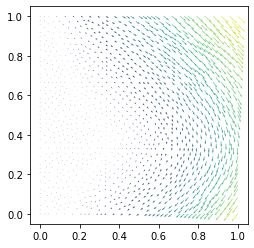

In [12]:
online_mu = (1.0, -1.0)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
print(reduced_solution)
plot(reduced_solution, reduced_problem=reduced_problem)

[-1.93941426  0.56101668 -0.0928978   0.08432793]


RONN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=4, bias=True)
  )
)

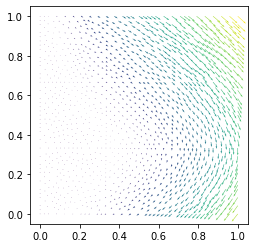

In [13]:
net.eval()

with torch.no_grad():
    online_mu_nn = torch.tensor(online_mu)
    reduced_solution_nn = net.solve(online_mu_nn, input_normalization, output_normalization)
    print(reduced_solution_nn)
    plot(reduced_solution_nn, reduced_problem=reduced_problem)

net.train()

0.007965959686913469


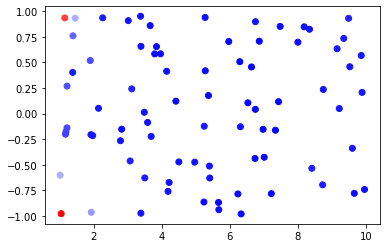

In [14]:
errors, error_plot = NN.plot_error(net, test_mu, input_normalization)
print(np.mean(errors))
error_plot

### 4.7. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()